# 7. Vorlesung Nichtlineare Regelungstechnik 1

## Vorlesungsbeispiel zur Gleitregime-Regelung (Sliding-Mode-Control)

System:

\begin{align*}
\dot x_1(t) &= x_2\\
\dot x_2(t) &= -a(t) \dot x_2^2(t) \cos(3 x_1(t)) + u(t)
\end{align*}

wobei über $a(t)$ nur bekannt ist: $1 < a(t) < 2$. Hierfür ist ein Gleitregime-Regler zu entwerfen, der den Ursprung des Systemes stabilisiert, ohne dass der genaue Verlauf von $a(t)$ bekannt ist.

### Hinweise

Zu diesem Notebook gibt es noch zwei weitere:

- `nl1-v7-01-slidingmode-beispiel`: Lösung der Grundaufgabe, ohne Abschätzungen
- `nl1-v7-03-slidingmode-beispiel`: Erweiterung um eine Trajektorienfolgeregelung

### Lösung

- Definition der Gleitfläche: 
  \begin{equation*}
  s(x_1, x_2) = x_2 + \lambda x_1 \qquad \text{mit} \qquad \lambda > 0
  \end{equation*}
  
  Es gilt:
  \begin{equation} \label{eq:sDot}
  \dot s(x_1, x_2) = \dot x_2 + \lambda \dot x_1 = -a(t) x_2^2 \cos(3 x_1) + u + \lambda x_2
  \end{equation}
  
- Gleitbedingung:
  \begin{equation*}
  \frac{1}{2} \frac{\text{d}}{\text{d}t} \left(s^2\right) =  s \dot s \stackrel{!}{\leq} \eta |s|
  \end{equation*}
  
  Mit dem Ausdruck für $\dot s$ ergibt sich:
  \begin{align*}
  a(t)x_2^2 \cos(3 x_1) + u + \lambda x_2 \quad &
  \begin{cases}
  \stackrel{!}{\leq} - \eta &\text{für} \, s > 0\\
  \stackrel{!}{\geq} \hphantom{-} \eta &\text{für} \, s < 0
  \end{cases}\\
  u \quad &
  \begin{cases}
  \stackrel{!}{\leq} - \eta + a(t) x_2^2 \cos(3 x_1) - \lambda x_2 &\text{für} \, s > 0\\
  \stackrel{!}{\geq} \hphantom{-} \eta + a(t) x_2^2 \cos(3 x_1) - \lambda x_2  &\text{für} \, s < 0
  \end{cases}
  \end{align*}

  Da $a(t)$ nicht genau bekannt, erfolgt jetzt eine worst-case-Abschätzung:
  \begin{align*}
  u \quad &
  \begin{cases}
  \stackrel{!}{\leq} - \eta - 2 x_2^2 |\cos(3 x_1)| - \lambda x_2 &\text{für} \, s > 0\\
  \stackrel{!}{\geq} \hphantom{-} \eta + 2 x_2^2 |\cos(3 x_1)| - \lambda x_2  &\text{für} \, s < 0
  \end{cases}
  \end{align*}
  
- Resultierender Regler:
  \begin{equation*}
  u = -(\eta + 2 x_2^2 |\cos(3 x_1)|)\cdot \text{sgn}(s) - \lambda x_2
  \end{equation*}


---

Die aktuelle Fassung dieses Notebooks findet sich in folgendem Repositorium:

https://gitlab.hrz.tu-chemnitz.de/rst/public/teaching/nl1-nbviewer-content

Sie können zur Entwicklung/ Verbesserung über Merge Requests beitragen!

---

<p style="font-family:Courier New; font-size:10pt">
Copyright (c) 2022-2023 Jan Winkler, TU Dresden, Germany
</p>

<p style="font-family:Courier New; font-size:10pt">
This program is free software: you can redistribute it and/or modify<br>
it under the terms of the GNU General Public License as published by<br>
the Free Software Foundation, either version 3 of the License, or<br>
(at your option) any later version.
</p>
    
<p style="font-family:Courier New; font-size:10pt">
This program is distributed in the hope that it will be useful,<br>
but WITHOUT ANY WARRANTY; without even the implied warranty of<br>
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the<br>
GNU General Public License for more details: <br>
<a href=https://www.gnu.org/licenses/gpl-3.0.txt>https://www.gnu.org/licenses/gpl-3.0.txt</a>.
</p>

---

## Vorbereitung der Simulation

### Import benötigter Module

In [1]:
import numpy as np
import scipy.integrate as sci
import matplotlib.pyplot as plt

### Simulationsparameter

In [2]:
# Anfangsbedingungen
x10 = 2
x20 = 0

# Simulationsdauer
t_sim = 10

# Abtastzeit Regler
t_sample = 0.05

# Anzahl der Auswertungen des zeitkont. Systems zwischen den Abtastschritten
refine_factor = 10

### Reglerparameter

Um das Klappern zu unterdrücken bzw. abzumildern kann `anti_chatter` auf `True` gesetzt werden. Dann wird im Regelgesetz statt der Signum-Funktion die Sättigungsfunktion mit dem Band $ \pm \epsilon$ (Parameter `chatter_band`) verwendet.

In [3]:
# Regler
plambda = 1
peta = 1

# Einfache Anti-Klapper-Vorrichtung
anti_chatter = False
chatter_band = 0.2

## Definition benötigter Funktionen

### Funktion $a(t)$ in der Systemdgl.

Erhöhen Sie die Amplitude deutlich, um die Robustheit des Entwurfs zu testen

In [4]:
def a_func(t):
    """
    Implementation der Funktion a(t) der Systemdynamik
    """

    return 0.5 * np.sin(t) + 1.5

### Rechte Seite des Systemdifferenzialgleichungssystems

In [5]:
def dgl_sys(t, x, u):
    """
    Implementation der rechten Seite des Differenzialgleichungssystems
    """
    x1, x2 = x

    x1_dot = x2
    x2_dot = -a_func(t) * x2**2 * np.cos(3 * x1) + u

    return [x1_dot, x2_dot]

### Definition des Stop-Events

Da der Regler das System bei Betrieb außerhalb der Spezifikation ggf. nicht stabilisieren kann, muss die Simulation in diesen Fällen abgebrochen werden. Ansonsten werden die Werte der Zustandskomponenten so groß, dass man auf dem Plot nichts erkennen kann. Hierzu wird dem Gleichungslöser diese sog. Event-Funktion übergeben, die ein Stop-Ereignis aulöst, sobald der Abstand des Zustands zum Ursprung größer ist als 10.

<div class="alert alert-block alert-info">
    <b>Tip:</b> Schauen Sie in der <a href=https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html>Dokumentation des Dgl-Lösers</a> nach, um sich genauer zu informieren. In Matlab ist unter dem Sichwort <a href=https://www.mathworks.com/help/matlab/math/ode-event-location.html>ode event</a> nachzusehen.
</div>

In [6]:
def stop_event(t, x):
    """
    Ereignisfunktion zum Anhalten der Simulation, falls Abstand der
    Zustandstrajektorie zum Ursprung größer als 10
    """
    return np.linalg.norm(x) - 10


# Attribute, die der obigen Funktion übergeben werden können (Python-Spezialität)
stop_event.terminal = True  # Im Ereignisfall anhalten
stop_event.direction = 1    # Wenn norm(x) - 10 größer Null wird

### Regelgesetz 1 (mit Klappern)

In [7]:
def sliding_mode_controller(x, para_lambda, para_eta):
    """
    Implementierung des Regelgesetzes unter der Annahme, dass a(t) < 2
    """
    x1, x2 = x

    s = x2 + para_lambda * x1

    return -(para_eta + 2 * x2**2 * np.abs(np.cos(3 * x1))) * np.sign(s) - para_lambda * x2

### Regelgesetz 2 (ohne Klappern)

Die Sättigungsfunktion wird über die Funktion [np.clip()](https://numpy.org/doc/stable/reference/generated/numpy.clip.html) realisiert:

```python
(1 / eps) * np.clip(y, -eps, eps)
```

sorgt dafür, dass `y` im Intervall `[-eps, eps]` von -1 bis 1 durchläuft.

In [8]:
def sliding_mode_controller_nochatter(x, para_lambda, para_eta, para_eps):
    """
    Implementierung des Regelgesetzes unter der Annahme, dass a(t) < amax
    """
    assert para_eps > 0, "para_eps muss größer Null sein!"

    x1, x2 = x

    s = x2 + para_lambda * x1

    sat = (1 / para_eps) * np.clip(s, -para_eps, para_eps)

    return -(para_eta + 2 * x2**2 * np.abs(np.cos(3 * x1))) * sat - para_lambda * x2

## Durchführung der Simulation

In [9]:
t_control_steps = np.arange(0, t_sim + t_sample, t_sample)
x_control_steps = np.zeros((2, t_control_steps.size))  # 2 Zeilen, soviel Spalten wie Schritte
u_control_steps = np.zeros(t_control_steps.size)

t_cont = np.array([])
x_cont = np.ndarray((2, 0))

x_act = [x10, x20]

In [10]:
for i, t_act in enumerate(t_control_steps):
    x_control_steps[:, i] = x_act

    if anti_chatter:
        u_act = sliding_mode_controller_nochatter(x_act, plambda, peta, chatter_band)
    else:
        u_act = sliding_mode_controller(x_act, plambda, peta)
    u_control_steps[i] = u_act

    sol = sci.solve_ivp(lambda t, x: dgl_sys(t, x, u_act), [t_act, t_act + t_sample], x_act, 
                        t_eval=np.linspace(t_act, t_act + t_sample, refine_factor), 
                        events=[stop_event])

    # Ein Status ungleich null bedeutet, dass das Stop-Event ausgelöst wurde.
    if sol.status != 0:
        print("Simulation wegen mutmaßlicher Instabilität abgebrochen bei t = {} s".format(sol.t_events[0][0]))
        break

    x_act = sol.y[:, -1]

    # Ineffektiv, aber besser zu Veranschaulichung. Siehe Notebook zur Übung
    # für bessere Variante
    t_cont = np.hstack((t_cont, sol.t[0:-1]))
    x_cont = np.hstack((x_cont, sol.y[:, 0:-1]))

## Darstellung der Ergebnisse

`%matplotlib widget` entkommentieren für bessere Grafiken (erfordert ipywidgets)

In [11]:
#%matplotlib widget
plt.rcParams['font.size'] = '14'
plt.figure(figsize=(10, 6))

# Trajektorie Zustand
plt.plot(x_cont[0, :], x_cont[1, :])

# Abtastpunkte
plt.plot(x_control_steps[0, :], x_control_steps[1, :], '.', color='r')

# Gleitfläche
x1_sl = np.array(plt.xlim())
x2_sl = -plambda * x1_sl
plt.plot(x1_sl, x2_sl)

plt.grid()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

Text(0, 0.5, '$x_2$')

Zeitverläufe

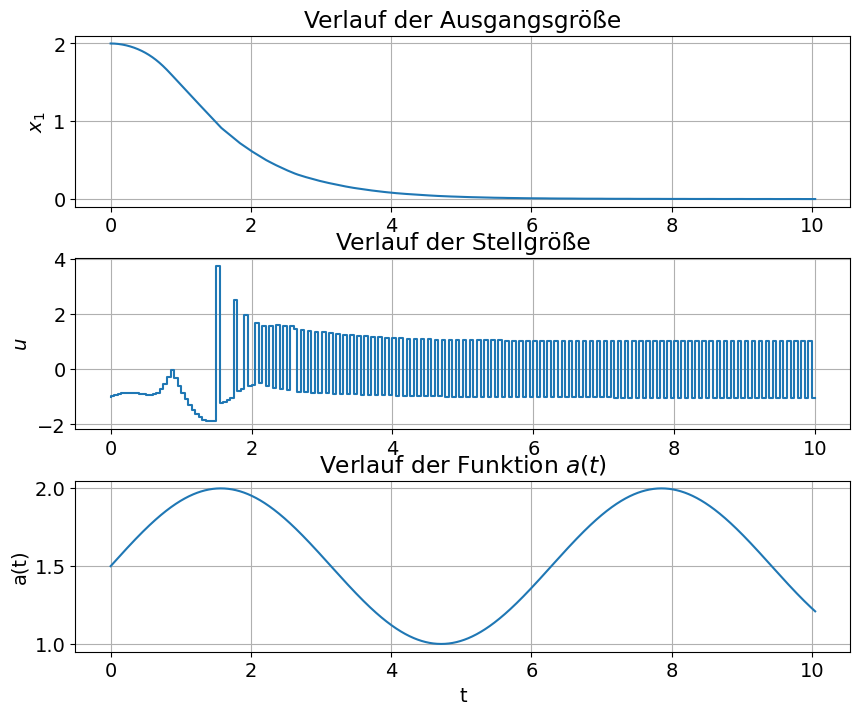

In [12]:
fig = plt.figure(figsize=(10, 8))
plt.subplot(311)
plt.plot(t_cont, x_cont[0,:])
plt.title('Verlauf der Ausgangsgröße')
plt.ylabel('$x_1$')
plt.grid()

plt.subplot(312)
plt.step(t_control_steps, u_control_steps)
plt.title('Verlauf der Stellgröße')
plt.ylabel('$u$')
plt.grid()

plt.subplot(313)
plt.plot(t_cont, a_func(t_cont))
plt.title('Verlauf der Funktion $a(t)$')
plt.grid()
plt.xlabel('t')
plt.ylabel('a(t)')

fig.subplots_adjust(hspace=0.3)
